In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Проверка стационарности

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm  # Для прогресс-бара

# 1. Загрузка данных
data_path = "Код\\traintest\\train.csv"
df = pd.read_csv(data_path, parse_dates=['dt'])
df = df.sort_values('dt').set_index('dt')

# 2. Отберем только числовые колонки
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Проверяемые колонки: {numeric_cols}")

# 3. Функция для проверки стационарности
def check_stationarity(series, alpha=0.05, plot=True):
    """Проверяет стационарность ряда с помощью ADF теста и визуализации"""
    # ADF тест
    result = adfuller(series.dropna())
    p_value = result[1]
    is_stationary = p_value < alpha
    
    # Визуализация
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(series, label='Исходный ряд')
        plt.plot(series.rolling(12).mean(), label='Скользящее среднее')
        plt.plot(series.rolling(12).std(), label='Скользящее СКО')
        plt.title(f"{series.name}\nADF p-value: {p_value:.4f} | Стационарность: {is_stationary}")
        plt.legend()
        plt.show()
    
    return {
        'adf_statistic': result[0],
        'p_value': p_value,
        'is_stationary': is_stationary,
        'critical_values': result[4]
    }

# 4. Проверяем все числовые колонки
results = []
for col in tqdm(numeric_cols, desc="Проверка стационарности"):
    try:
        res = check_stationarity(df[col], plot=False)  # Установите plot=True для графиков
        results.append({
            'Колонка': col,
            'ADF Статистика': res['adf_statistic'],
            'p-value': res['p_value'],
            'Стационарность': res['is_stationary'],
            'Критические значения (1%)': res['critical_values']['1%'],
            'Критические значения (5%)': res['critical_values']['5%'],
            'Критические значения (10%)': res['critical_values']['10%']
        })
    except Exception as e:
        print(f"Ошибка в колонке {col}: {str(e)}")

# 5. Результаты в таблицу
results_df = pd.DataFrame(results).set_index('Колонка')
print("\nРезультаты тестов на стационарность:")
print(results_df.sort_values('Стационарность'))

# 6. Статистика по стационарности
stationary_cnt = results_df['Стационарность'].sum()
print(f"\nСтационарных колонок: {stationary_cnt}/{len(numeric_cols)} ({stationary_cnt/len(numeric_cols):.1%})")

Проверяемые колонки: ['Цена на арматуру']


Проверка стационарности: 100%|██████████| 1/1 [00:00<00:00, 76.89it/s]


Результаты тестов на стационарность:
                  ADF Статистика   p-value  Стационарность  \
Колонка                                                      
Цена на арматуру        -1.92587  0.319991           False   

                  Критические значения (1%)  Критические значения (5%)  \
Колонка                                                                  
Цена на арматуру                  -3.447057                  -2.868904   

                  Критические значения (10%)  
Колонка                                       
Цена на арматуру                   -2.570693  

Стационарных колонок: 0/1 (0.0%)


Обучение модели
1. Загрузка данных

In [3]:
# Загрузка данных
df = pd.read_csv('Код\\traintest\\train.csv', parse_dates=['dt'])
df = df.rename(columns={'Цена на арматуру': 'price'})

# Проверка наличия необходимых колонок
assert 'price' in df.columns, "Колонка с ценой не найдена"
assert 'dt' in df.columns, "Колонка с датой не найдена"

2. Добавление временных признаков

In [4]:
# Создание временных признаков
def create_features(df):
    df = df.copy()
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['week_of_year'] = df['dt'].dt.isocalendar().week
    
    for lag in range(1, 7):
        df[f'price_lag_{lag}'] = df['price'].shift(lag)
    
    df['rolling_mean_4'] = df['price'].rolling(4).mean().shift(1)
    df['rolling_std_4'] = df['price'].rolling(4).std().shift(1)
    return df

df = create_features(df).dropna()

3. Обучение

In [5]:
# Разделение данных
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop(['dt', 'price'], axis=1)
y_train = train['price']
X_test = test.drop(['dt', 'price'], axis=1)
y_test = test['price']

# Обучение модели
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Сохранение модели с метаданными
model_data = {
    'model': model,
    'features': X_train.columns.tolist(),
    'metrics': {
        'R2': r2_score(y_test, model.predict(X_test)),
        'MSE': mean_squared_error(y_test, model.predict(X_test)),
        'MAE': mean_absolute_error(y_test, model.predict(X_test))
    }
}


joblib.dump(model_data, "xgboost_model.pkl")

['xgboost_model.pkl']

4. Прогноз и оценка

Метрики качества модели:
R2: -0.53
MAE: 9987.70


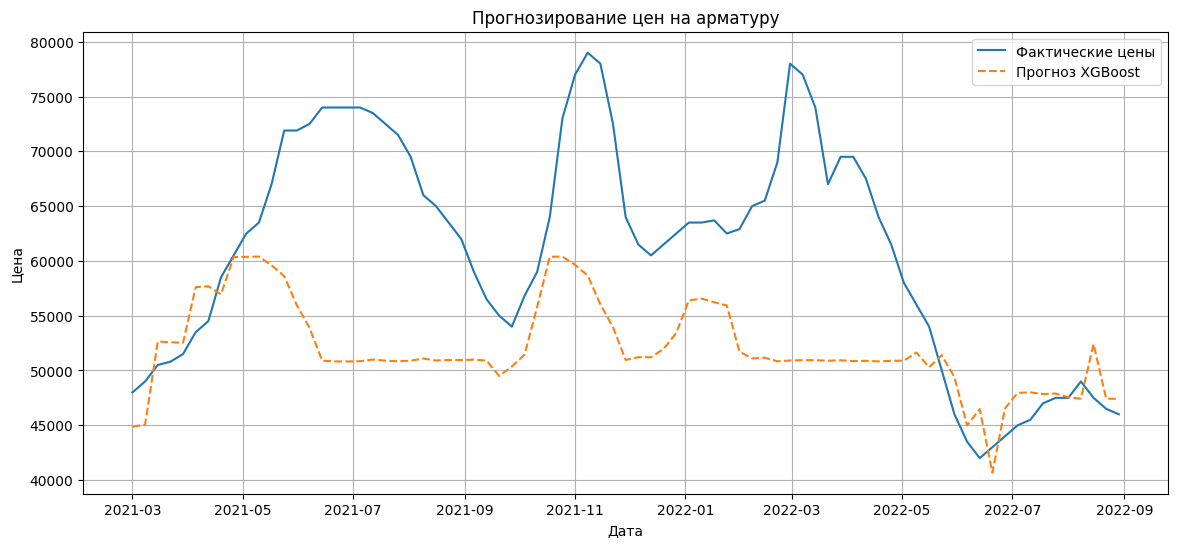

In [6]:
# Прогнозирование и оценка
y_pred = model.predict(X_test)

# Метрики качества
metrics = {
    'R2': r2_score(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred)
}

print("Метрики качества модели:")
for k, v in metrics.items():
    print(f"{k}: {v:.2f}")

# Визуализация прогнозов
plt.figure(figsize=(14,6))
plt.plot(test['dt'], y_test, label='Фактические цены')
plt.plot(test['dt'], y_pred, label='Прогноз XGBoost', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

# Генерация рекомендаций
def calculate_optimal_N(current_price, predictions):
    savings = []
    for N in range(1,7):
        predicted_total = sum(predictions[:N])
        fixed_total = current_price * N
        savings.append(fixed_total - predicted_total)
    return np.argmax(savings) + 1

recommendations = []
for i in range(len(y_test)-6):
    window_pred = y_pred[i:i+6]
    current_price = y_test.iloc[i]
    recommendations.append(calculate_optimal_N(current_price, window_pred))


In [7]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import xgboost as xgb
import joblib 
from datetime import datetime, timedelta

class ProcurementRecommender:
    def __init__(self, master):
        self.master = master
        self.master.title("Рекомендационная система закупок")
        
        # Загрузка модели и данных
        self.load_model_and_data()
        
        # Создание интерфейса
        self.create_widgets()
        self.show_current_price()

    def load_model_and_data(self):
        """Загрузка модели и данных с обработкой исключений"""
        try:
            # Загрузка модели
            # with open('xgboost_model.pkl', 'rb') as f:
            #     self.model = joblib.load(f)  # Или pickle.load(f)
            self.model = model
            
            # Загрузка данных
            self.data = pd.read_csv('Код\\traintest\\train.csv')
            
            # Проверка необходимых колонок
            if 'dt' not in self.data or 'Цена на арматуру' not in self.data:
                raise ValueError("CSV-файл должен содержать колонки 'date' и 'price'")
                
        except Exception as e:
            tk.messagebox.showerror("Ошибка загрузки", f"Ошибка: {str(e)}")
            self.master.destroy()

    def create_widgets(self):
        self.main_frame = ttk.Frame(self.master, padding="15")
        self.main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Информация о текущей цене
        self.current_price_header = ttk.Label(self.main_frame, 
                                            text="Текущая ситуация на рынке:",
                                            font=('Helvetica', 12, 'bold'))
        self.current_price_header.grid(row=0, column=0, columnspan=2, pady=5, sticky=tk.W)
        
        self.current_price_label = ttk.Label(self.main_frame, text="Цена: ")
        self.current_price_label.grid(row=1, column=0, sticky=tk.W)
        
        self.price_date_label = ttk.Label(self.main_frame, text="Дата: ")
        self.price_date_label.grid(row=1, column=1, sticky=tk.W)
        
        # Кнопка прогноза
        self.predict_button = ttk.Button(self.main_frame, 
                                       text="Получить рекомендацию", 
                                       command=self.predict_recommendation)
        self.predict_button.grid(row=2, column=0, columnspan=2, pady=10)
        
        # Результаты прогноза
        self.recommendation_header = ttk.Label(self.main_frame, 
                                             text="Рекомендация по закупке:",
                                             font=('Helvetica', 12, 'bold'))
        self.recommendation_header.grid(row=3, column=0, columnspan=2, pady=5, sticky=tk.W)
        
        self.forecast_label = ttk.Label(self.main_frame, text="Прогноз цены: ")
        self.forecast_label.grid(row=4, column=0, columnspan=2, sticky=tk.W)
        
        self.recommendation_label = ttk.Label(self.main_frame, 
                                            text="Рекомендуемый объем закупки: ",
                                            font=('Helvetica', 10, 'bold'))
        self.recommendation_label.grid(row=5, column=0, columnspan=2, pady=5, sticky=tk.W)

    def show_current_price(self):
        """Отображает текущую цену и дату"""
        last_row = self.data.iloc[-1]
        current_price = last_row['Цена на арматуру']
        price_date = last_row['dt']
        
        self.current_price_label.config(text=f"Цена: {current_price:.2f} руб/т")
        self.price_date_label.config(text=f"Дата: {price_date}")

    def prepare_features(self):
        """Подготовка данных для прогноза"""
        # Убедитесь, что названия колонок совпадают с тренировочными данными
        features = self.data.tail(7).drop(['dt', 'Цена на арматуру'], axis=1)
        return features  # Возвращаем DataFrame вместо DMatrix

    def predict_recommendation(self):
        """Выполнение прогноза и вывод результатов"""
        try:
            # Получение прогноза
            features = self.prepare_features()
            prediction = self.model.predict(features)
            
            # ... (остальная логика остается без изменений)

        except Exception as e:
            self.recommendation_label.config(
                text=f"Ошибка: {str(e)}",
                foreground="red"
            )

if __name__ == "__main__":
    root = tk.Tk()
    app = ProcurementRecommender(root)
    root.mainloop()